<a href="https://colab.research.google.com/github/vineet891/FODS-Assignment/blob/PartA/Assignment1/FODS_A1_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Polynomial Regression

In this assignment, we perform Polynomial Regression, using 
polynomials of degrees 0 to 9 without regularization.
 
The general polynomial of order M is of the form,
     
                y(x,w) = w0 + w1x1 + w2x2 + . . . + wMxM 
 
The polynomial coefficients w0, . . . , wM are collectively denoted by the vector w. The values of the coefficients will be determined by fitting the polynomial to the training data. This can be done by minimizing an error function that measures the misfit between the function y(x,w), for any given value of w, and the training set data points.  We use the Sum of Squares error function in this assignment

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

import tqdm
from tqdm import notebook

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


### Loading Data

In [4]:
df = pd.read_csv('/content/gdrive/My Drive/FODSAssignment/FoDS-A1.csv')
df

Strength  Temperature  Pressure
0         30.7          240        16
1         24.7          250        18
2         30.6          260        16
3         32.8          240        10
4         20.7          240        20
...        ...          ...       ...
1645      32.5          270        20
1646      38.6          290        14
1647      39.7          290        12
1648      14.6          200        20
1649      19.8          210        20

[1650 rows x 3 columns]

### Data Preprocessing

Before implementing the algorithms, we pre-process the data which includes,
* Shuffling the data, 
* Standardizing the values, and 
* creating a random 70-30 split to aid in training and testing respectively.


In [5]:
df = df.sample(frac=1).reset_index(drop=True)
df

Strength  Temperature  Pressure
0         13.7          200        20
1         46.5          300        12
2         32.7          240        14
3         25.8          210        14
4         33.0          230        10
...        ...          ...       ...
1645      22.2          200        12
1646      17.7          200        16
1647      28.4          260        16
1648      42.2          290        10
1649      26.7          230        14

[1650 rows x 3 columns]

In [6]:
X_original = df.values[:,:-1]
y_original = df.values[:,-1]

In [7]:
df.describe()

Strength  Temperature     Pressure
count  1650.000000  1650.000000  1650.000000
mean     30.000000   250.000000    15.000000
std       7.390248    31.632364     3.416686
min      12.400000   200.000000    10.000000
25%      24.400000   220.000000    12.000000
50%      30.200000   250.000000    15.000000
75%      35.700000   280.000000    18.000000
max      48.700000   300.000000    20.000000

In [8]:
mu_df = np.mean(df,axis=0)
std_df = np.std(df,axis=0)

In [9]:
# standardize the dataset
df = (df-mu_df)/std_df
df

Strength  Temperature  Pressure
0    -2.206278    -1.581139   1.46385
1     2.233349     1.581139  -0.87831
2     0.365457    -0.316228  -0.29277
3    -0.568489    -1.264911  -0.29277
4     0.406063    -0.632456  -1.46385
...        ...          ...       ...
1645 -1.055765    -1.581139  -0.87831
1646 -1.664860    -1.581139   0.29277
1647 -0.216567     0.316228   0.29277
1648  1.651325     1.264911  -1.46385
1649 -0.446670    -0.632456  -0.29277

[1650 rows x 3 columns]

In [10]:
# Train-Test Split
# split the data set into 70:30 train:test 

split_index = int(0.7*len(df))

data = df.values
X = data[:,:-1]
y = data[:,-1]

train_X = X[:split_index]
train_y = y[:split_index]

test_X = X[split_index:]
test_y = y[split_index:]

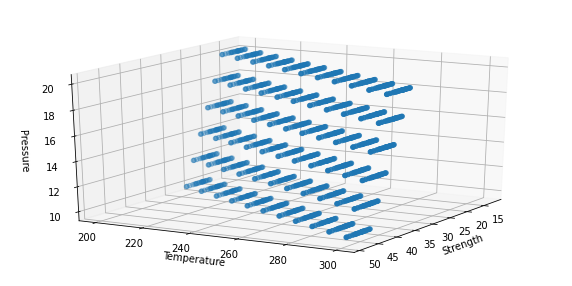

In [11]:
# Plot of Original Dataset
plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')
ax.scatter3D(X_original[:,0], X_original[:,1], y_original)
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(20,30)

plt.show()

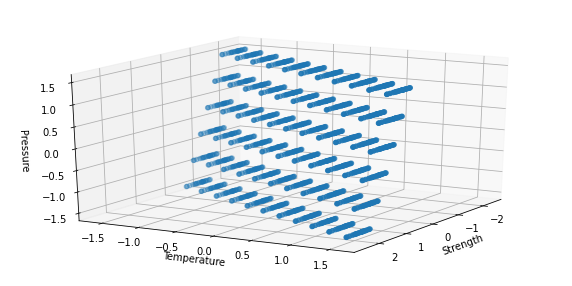

In [12]:
# Plot of Standardized datset
plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')
ax.scatter3D(X[:,0], X[:,1], y)
#ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(20,30)

plt.show()

In [36]:
# generate curve                   w0 + w1x + w2 y+ ...  
def genCurve(weight,xx,yy,degree):
  #X_trans = np.ones((len(X[:,1]), 1), dtype=int)
  Z=weight[0]
  count=0
  for i in range(degree+1):
    for j in range(degree+1-i):
      if i!=0 or j!=0:
        count=count+1
        Z+=weight[count]*(xx**i)*(yy**j)
  return Z    

### Model

In [75]:
class PolynomialRegression():

    def __init__(self, degree):
        self.w = None
        self.degree = degree

    def transform(self,X):
        '''
        Transforms the features to degree d polynomial features
        '''
        X_trans = np.ones((len(X[:,1]), 1), dtype=int) 
        for i in range(self.degree+1):
            for j in range(self.degree+1-i):
                if i!=0 or j!=0:
                    t = np.array([np.multiply(np.power(X[:,0],i),np.power(X[:,-1],j))])
                    X_trans = np.concatenate((X_trans, t.T), axis=1)
        return X_trans

    def polynomial(self, X):   
      '''
      Evaluates the polynomial by doing a dot product of the weights with the feature variables.
      ''' 
        return np.dot(X, self.w.T) 
    
    def mean_squared_error(self, y_pred, y):
        '''
        Evaluates the Mean Squared error of the predicted values by comparing it with the true values.
        Parameters:
            y_pred: Predicted values.
            y: True output values.
        '''
        return np.sum((y-y_pred)**2)/y.shape[0]

    def grad_w(self, x, y):    
        '''
        Calculates the gradient of the weight values.
        Parameters:
            x: Training point
            y:  
        '''
        y_pred = self.polynomial(x)  
        m = X.shape[0]
        # if regularizer is None:
        return (1/m)*x.T.dot(y_pred - y)
        # elif regularizer==1:
        #     return (1/m)*x.T.dot(y_pred - y) + ( (lam/2*m) * ( np.sign(self.w) ) )
        # elif regularizer==2:
        #     return (1/m)*x.T.dot(y_pred - y) + ( (lam/m) * ( self.w ) )

    def predict(self, X):
        '''
        Evaluates the sigmoid function value of the given data.
        Parameters:
            X: testing sample
        '''
        return self.polynomial(X)

    def evaluate(self, x_test, y_test):
        '''
        Evaluates the model for a given testing data
        Parameters:
            x_test: testing samples
            y_test: testing labels
        '''
        y_pred = self.predict(x_test)
        test_loss = self.mean_squared_error(y_pred, y_test)
        print("Testing MSE is ", test_loss)
        mae = (1/y_test.shape[0])*np.sum(np.absolute(y_pred-y_test))
        print("Testing MAE is ", mae)

    def fit(self, X,Y, epochs = 1, learning='GD', learning_rate = 1, display_loss=True, printValues=True):
      '''
        Performs Gradient descent or Stochastic Gradient descent as mentioned.
        Paremeters-
          X - training features
          Y - training target attributes
          epochs - number of iterations the gradient descent should run
          learning - learning rate for gradient update
          display_loss, printValues -  printing loss in each epoch

      '''

        count=0
        m = X.shape[0]

        self.w = np.random.randn(X.shape[1],)

        if display_loss:
            loss={}
            accuracy={}
        
        print("Training...")

        for i in tqdm.notebook.tqdm(range(epochs), total=epochs, unit="epoch"):
            
            dw = 0
            if learning == 'GD':

                y_estimated = self.predict(X)
                
                dw = self.grad_w(X, Y)
                self.w = self.w - (learning_rate * dw) 
                
                error = y_estimated - Y
                cost = (1 / 2 * m) * np.sum(error ** 2)             

            if learning == 'SGD':
                randInt = np.random.randint(0,X.shape[0])
                x = X[randInt, :]
                y = Y[randInt]
                Y_pred = self.predict(X)
                dw = x*(Y_pred[randInt] - y) 
                error = Y_pred - Y

                self.w -= learning_rate * dw

            if display_loss:
                Y_pred = self.polynomial(X)   
                loss[i] = self.mean_squared_error(Y_pred,Y)
                if i%50==0:
                    print('Epoch:', i,  ' MSE Loss :', loss[i])

        if display_loss and count%50==0:
            plt.subplot(2, 1, 1)
            plt.plot(list(loss.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Mean Squared Error')
            
            plt.show()
        count=count+1

        print("Testing")


### 0 Degree Polynomial

##### Gradient Descent

Training...


  0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  2578407.0670544864  MSE Loss : 3.82529485606643
Epoch: 50  Cost :  1605829.5275586953  MSE Loss : 2.3875270327613407
Epoch: 100  Cost :  1124049.1746892517  MSE Loss : 1.6753079436639677
Epoch: 150  Cost :  885392.3077711262  MSE Loss : 1.3224999153770147
Epoch: 200  Cost :  767170.1764867256  MSE Loss : 1.1477313550713957
Epoch: 250  Cost :  708607.1336297992  MSE Loss : 1.0611572206345907
Epoch: 300  Cost :  679597.083215366  MSE Loss : 1.018271470815657
Epoch: 350  Cost :  665226.5351018739  MSE Loss : 0.9970273942852159
Epoch: 400  Cost :  658107.8762187633  MSE Loss : 0.9865038336727353
Epoch: 450  Cost :  654581.5455670805  MSE Loss : 0.9812908356962939


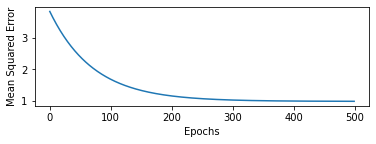

Testing
Testing MSE is  1.0614268606304513
Testing MAE is  0.912535309411559


In [21]:
GD0 = PolynomialRegression(0)
x_train_trans_0 = GD0.transform(train_X)
GD0.fit(x_train_trans_0, train_y, epochs = 500, learning='GD', learning_rate=0.01)
x_test_trans_0 = GD0.transform(test_X)
GD0.evaluate(x_test_trans_0 , test_y)

In [22]:
wGD0 = GD0.w

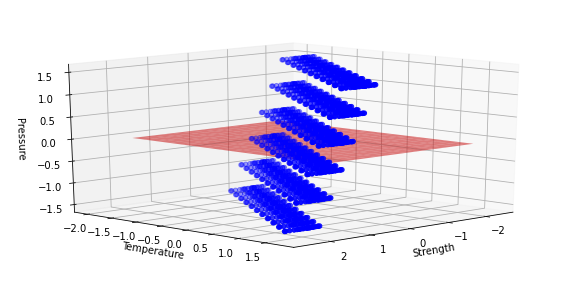

In [91]:
# plot for 0 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
Z = (np.array([wGD0]) * 1)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

##### Stochastic Gradient Descent

Training...


  0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch: 0  MSE Loss : 1.7323667915529526
Epoch: 50  MSE Loss : 1.2752233059121134
Epoch: 100  MSE Loss : 1.057037233659229
Epoch: 150  MSE Loss : 1.0595593007181512
Epoch: 200  MSE Loss : 0.9975932459477024
Epoch: 250  MSE Loss : 0.9774469797970498
Epoch: 300  MSE Loss : 0.9791912488966862
Epoch: 350  MSE Loss : 0.9762466490081706
Epoch: 400  MSE Loss : 0.9826720104277772
Epoch: 450  MSE Loss : 0.9761858029813477


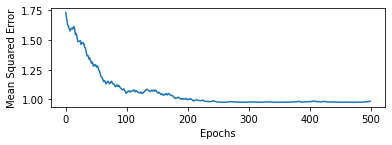

Testing
Testing MSE is  1.0720366904942185
Testing MAE is  0.9144666100924104


In [92]:
SGD0 = PolynomialRegression(0)
x_train_trans_0 = SGD0.transform(train_X)
SGD0.fit(x_train_trans_0, train_y, epochs = 500, learning='SGD', learning_rate=0.01)
x_test_trans_0 = SGD0.transform(test_X)
SGD0.evaluate(x_test_trans_0 , test_y)

In [93]:
wSGD0 = SGD0.w

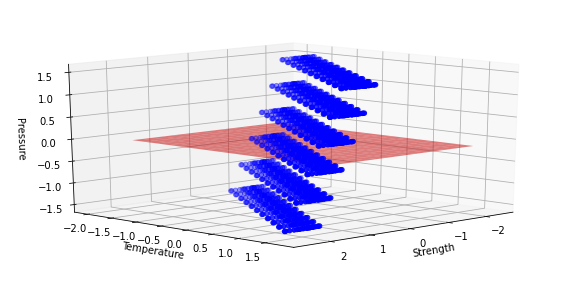

In [94]:
# plot for 0 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
Z = (np.array([wSGD0]) * 1)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

### 1 Degree Polynomial

##### GD

Training...


  0%|          | 0/2000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  2288038.5810981803  MSE Loss : 3.360773002917144
Epoch: 50  Cost :  1151139.6121786607  MSE Loss : 1.7108804844555383
Epoch: 100  Cost :  822299.5095287056  MSE Loss : 1.226057874120772
Epoch: 150  Cost :  639082.6731087483  MSE Loss : 0.9536193102201087
Epoch: 200  Cost :  509925.6903720678  MSE Loss : 0.7611943628607561
Epoch: 250  Cost :  414521.7658977164  MSE Loss : 0.6190091762390408
Epoch: 300  Cost :  343495.585885597  MSE Loss : 0.5131495954729105
Epoch: 350  Cost :  290550.73864267324  MSE Loss : 0.43423828997486147
Epoch: 400  Cost :  251076.08589170163  MSE Loss : 0.3754034653241992
Epoch: 450  Cost :  221643.57121441732  MSE Loss : 0.3315358916737784
Epoch: 500  Cost :  199698.41127670367  MSE Loss : 0.2988278147048415
Epoch: 550  Cost :  183335.8793236957  MSE Loss : 0.2744403434245491
Epoch: 600  Cost :  171135.80923458943  MSE Loss : 0.2562567970114976
Epoch: 650  Cost :  162039.31280192645  MSE Loss : 0.24269895972883052
Epoch: 700  Cost :  155256.872

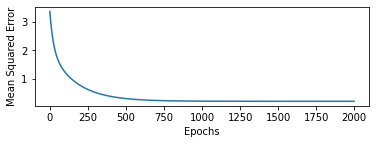

Testing
Testing MSE is  0.19327247984737836
Testing MAE is  0.35131608596163466


In [32]:
GD1 = PolynomialRegression(1)
x_train_trans_1 = GD1.transform(train_X)
GD1.fit(x_train_trans_1, train_y, epochs = 2000, learning='GD', learning_rate=0.03)
x_test_trans_1 = GD1.transform(test_X)
GD1.evaluate(x_test_trans_1 , test_y)

In [39]:
wGD1 = GD1.w

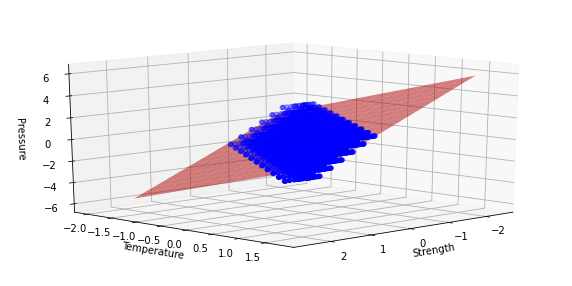

In [38]:
# plot for 0 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
Z=genCurve(wGD1,xx,yy,1)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

##### Stochastic Gradient Descent

Training...


  0%|          | 0/2000 [00:00<?, ?epoch/s]

Epoch: 0  MSE Loss : 1.0821551818342043
Epoch: 50  MSE Loss : 0.8322925493694056
Epoch: 100  MSE Loss : 0.6010430069017816
Epoch: 150  MSE Loss : 0.46910772074673174
Epoch: 200  MSE Loss : 0.3904518040580708
Epoch: 250  MSE Loss : 0.33834724935987076
Epoch: 300  MSE Loss : 0.3076051765703738
Epoch: 350  MSE Loss : 0.295840896852039
Epoch: 400  MSE Loss : 0.27828960912799033
Epoch: 450  MSE Loss : 0.2684739866480602
Epoch: 500  MSE Loss : 0.2636480274865658
Epoch: 550  MSE Loss : 0.2532681592470589
Epoch: 600  MSE Loss : 0.2487061268376084
Epoch: 650  MSE Loss : 0.24209609965565584
Epoch: 700  MSE Loss : 0.23823450771120275
Epoch: 750  MSE Loss : 0.23652628287834482
Epoch: 800  MSE Loss : 0.2321216439606909
Epoch: 850  MSE Loss : 0.23019906553202849
Epoch: 900  MSE Loss : 0.22860177961617786
Epoch: 950  MSE Loss : 0.2264769102658715
Epoch: 1000  MSE Loss : 0.22551126490954765
Epoch: 1050  MSE Loss : 0.2252415967734593
Epoch: 1100  MSE Loss : 0.22545023921993365
Epoch: 1150  MSE Loss : 0

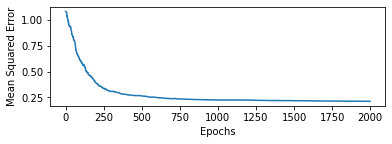

Testing
Testing MSE is  0.20760871673426864
Testing MAE is  0.37099574709391864


In [95]:
SGD1 = PolynomialRegression(1)
x_train_trans_1 = SGD1.transform(train_X)
SGD1.fit(x_train_trans_1, train_y, epochs = 2000, learning='SGD', learning_rate=0.003)
x_test_trans_1 = SGD1.transform(test_X)
SGD1.evaluate(x_test_trans_1 , test_y)

In [97]:
wSGD1 = SGD1.w

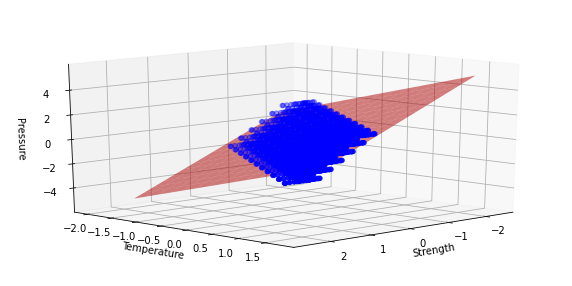

In [98]:
# plot for 1 degree polynomial SGD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
Z=genCurve(wSGD1,xx,yy,1)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

### 2 Degree Polynomial

##### GD

Training...


  0%|          | 0/2000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  2467471.519698229  MSE Loss : 3.372931579052227
Epoch: 50  Cost :  674031.7516013959  MSE Loss : 1.0027952345057034
Epoch: 100  Cost :  497885.92177911365  MSE Loss : 0.742753706638717
Epoch: 150  Cost :  400504.844502084  MSE Loss : 0.5981508478303331
Epoch: 200  Cost :  337079.93275009346  MSE Loss : 0.5037960760285621
Epoch: 250  Cost :  292723.7995829491  MSE Loss : 0.43773398677547515
Epoch: 300  Cost :  260147.9295350853  MSE Loss : 0.38917662185694546
Epoch: 350  Cost :  235361.41336269974  MSE Loss : 0.35220819566007805
Epoch: 400  Cost :  216028.99601328862  MSE Loss : 0.3233627192817627
Epoch: 450  Cost :  200694.63424945404  MSE Loss : 0.30047640359283473
Epoch: 500  Cost :  188393.24297174226  MSE Loss : 0.28211338883239917
Epoch: 550  Cost :  178449.6622195616  MSE Loss : 0.2672681813686691
Epoch: 600  Cost :  170370.39904755325  MSE Loss : 0.2552052746606998
Epoch: 650  Cost :  163782.52496208693  MSE Loss : 0.24536853711389278
Epoch: 700  Cost :  158397

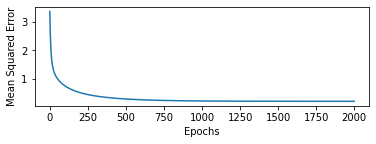

Testing
Testing MSE is  0.19367616934104903
Testing MAE is  0.351446626586529


In [53]:
GD2 = PolynomialRegression(2)
x_train_trans_2 = GD2.transform(train_X)
GD2.fit(x_train_trans_2, train_y, epochs = 2000, learning='GD', learning_rate=0.02)
x_test_trans_2 = GD2.transform(test_X)
GD2.evaluate(x_test_trans_2 , test_y)

In [55]:
wGD2 = GD2.w

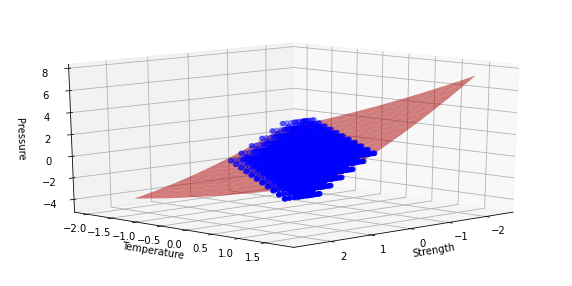

In [56]:
# plot for 0 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
Z=genCurve(wGD2,xx,yy,2)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

##### Stochastic Gradient Descent

Training...


  0%|          | 0/2500 [00:00<?, ?epoch/s]

Epoch: 0  MSE Loss : 2.9327737366135196
Epoch: 50  MSE Loss : 1.9483645067659874
Epoch: 100  MSE Loss : 2.1661061091314604
Epoch: 150  MSE Loss : 0.8808093369247105
Epoch: 200  MSE Loss : 0.7666357088102479
Epoch: 250  MSE Loss : 0.6102669330001026
Epoch: 300  MSE Loss : 0.5294342037377817
Epoch: 350  MSE Loss : 0.4601808041123964
Epoch: 400  MSE Loss : 0.4402190833228442
Epoch: 450  MSE Loss : 0.4184849922173948
Epoch: 500  MSE Loss : 0.3340390649870115
Epoch: 550  MSE Loss : 0.30010079141109053
Epoch: 600  MSE Loss : 0.2753935819336081
Epoch: 650  MSE Loss : 0.25894616431930406
Epoch: 700  MSE Loss : 0.28923625039668777
Epoch: 750  MSE Loss : 0.24336365146174413
Epoch: 800  MSE Loss : 0.28250778991021314
Epoch: 850  MSE Loss : 0.25176532948648556
Epoch: 900  MSE Loss : 0.2647001476643619
Epoch: 950  MSE Loss : 0.2388973177685234
Epoch: 1000  MSE Loss : 0.23222143737330359
Epoch: 1050  MSE Loss : 0.22508108876223507
Epoch: 1100  MSE Loss : 0.24507448227351716
Epoch: 1150  MSE Loss : 0

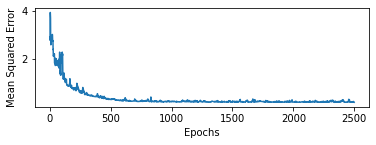

Testing
Testing MSE is  0.20440414494786002
Testing MAE is  0.3554959176431858


In [100]:
SGD2 = PolynomialRegression(2)
x_train_trans_2 = SGD2.transform(train_X)
SGD2.fit(x_train_trans_2, train_y, epochs = 2500, learning='SGD', learning_rate=0.02)
x_test_trans_2 = SGD2.transform(test_X)
SGD2.evaluate(x_test_trans_2 , test_y)

In [102]:
wSGD2 = SGD2.w

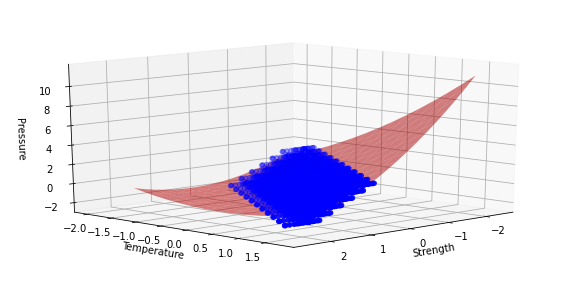

In [103]:
# plot for 1 degree polynomial SGD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
Z=genCurve(wSGD2,xx,yy,2)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

### 3 Degree Polynomial

###### GD

Training...


  0%|          | 0/3000 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  15648743.468740154  MSE Loss : 19.689809841490355
Epoch: 50  Cost :  940739.7391622831  MSE Loss : 1.4001171967394628
Epoch: 100  Cost :  737525.0298239972  MSE Loss : 1.1017603254080188
Epoch: 150  Cost :  631457.8256091884  MSE Loss : 0.9441212734576491
Epoch: 200  Cost :  558460.5968034206  MSE Loss : 0.8354102630220478
Epoch: 250  Cost :  505088.5549925632  MSE Loss : 0.7558629026336017
Epoch: 300  Cost :  464632.4751885693  MSE Loss : 0.6955242184056987
Epoch: 350  Cost :  432897.5429752377  MSE Loss : 0.6481607047533131
Epoch: 400  Cost :  407168.3518306835  MSE Loss : 0.6097361705930457
Epoch: 450  Cost :  385670.7846028424  MSE Loss : 0.5776131646073002
Epoch: 500  Cost :  367236.4956870358  MSE Loss : 0.5500544883352687
Epoch: 550  Cost :  351088.3763342195  MSE Loss : 0.5259044062278425
Epoch: 600  Cost :  336702.8202849851  MSE Loss : 0.5043839694324814
Epoch: 650  Cost :  323721.14569098334  MSE Loss : 0.4849593827397944
Epoch: 700  Cost :  311892.53588424

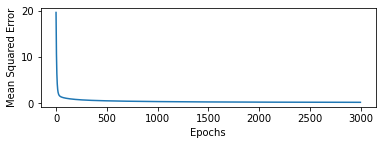

Testing
Testing MSE is  0.21429151729009435
Testing MAE is  0.37909749404066273


In [61]:
GD3 = PolynomialRegression(3)
x_train_trans_3 = GD3.transform(train_X)
GD3.fit(x_train_trans_3, train_y, epochs = 3000, learning='GD', learning_rate=0.02)
x_test_trans_3 = GD3.transform(test_X)
GD3.evaluate(x_test_trans_3 , test_y)

In [62]:
wGD3 = GD3.w

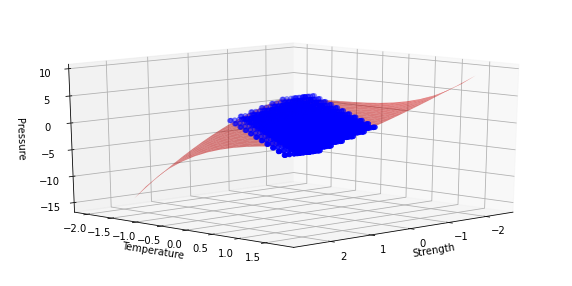

In [63]:
# plot for 0 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
Z=genCurve(wGD3,xx,yy,3)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

###### SGD

Training...


  0%|          | 0/5500 [00:00<?, ?epoch/s]

Epoch: 0  MSE Loss : 10.216180101766305
Epoch: 50  MSE Loss : 1.125005644012731
Epoch: 100  MSE Loss : 0.7625759971760221
Epoch: 150  MSE Loss : 0.8391528848509744
Epoch: 200  MSE Loss : 0.718721337400912
Epoch: 250  MSE Loss : 0.5389436414565353
Epoch: 300  MSE Loss : 0.8388367266359531
Epoch: 350  MSE Loss : 0.465322674923351
Epoch: 400  MSE Loss : 0.4337136393072812
Epoch: 450  MSE Loss : 0.4382014865041756
Epoch: 500  MSE Loss : 0.4171609819776876
Epoch: 550  MSE Loss : 0.557823930692843
Epoch: 600  MSE Loss : 0.3836288910430213
Epoch: 650  MSE Loss : 0.4101232163662953
Epoch: 700  MSE Loss : 0.36977192617610277
Epoch: 750  MSE Loss : 0.6060656957702313
Epoch: 800  MSE Loss : 0.6903140494308422
Epoch: 850  MSE Loss : 0.37554957129687466
Epoch: 900  MSE Loss : 0.35236102508256245
Epoch: 950  MSE Loss : 0.38300298411021266
Epoch: 1000  MSE Loss : 0.3956062687688056
Epoch: 1050  MSE Loss : 0.39336477199307673
Epoch: 1100  MSE Loss : 0.47585157521741
Epoch: 1150  MSE Loss : 0.365884306

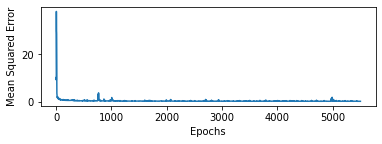

Testing
Testing MSE is  0.20600854784988648
Testing MAE is  0.3655799820074464


In [107]:
SGD3 = PolynomialRegression(3)
x_train_trans_3 = SGD3.transform(train_X)
SGD3.fit(x_train_trans_3, train_y, epochs = 5500, learning='SGD', learning_rate=0.01)
x_test_trans_3 = SGD3.transform(test_X)
SGD3.evaluate(x_test_trans_3 , test_y)

In [108]:
wSGD3 = SGD3.w

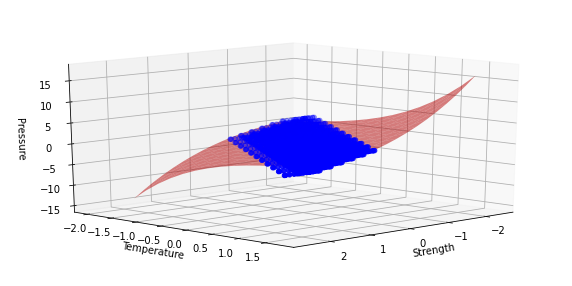

In [109]:
# plot for 0 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
Z=genCurve(wSGD3,xx,yy,3)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

### 4 Degree Polynomial

##### GD

Training...


  0%|          | 0/3500 [00:00<?, ?epoch/s]

Epoch: 0  Cost :  51640068.3816901  MSE Loss : 6.926764316413953
Epoch: 50  Cost :  1219511.8842416748  MSE Loss : 1.8093166586183012
Epoch: 100  Cost :  828869.5773382297  MSE Loss : 1.2351490776845306
Epoch: 150  Cost :  631722.9025542305  MSE Loss : 0.9424257037017587
Epoch: 200  Cost :  502048.14153997344  MSE Loss : 0.7494832801803859
Epoch: 250  Cost :  411922.9491585963  MSE Loss : 0.6153135860237042
Epoch: 300  Cost :  348048.0486000465  MSE Loss : 0.5201938962842585
Epoch: 350  Cost :  302135.41758694826  MSE Loss : 0.45180424038743533
Epoch: 400  Cost :  268676.740420465  MSE Loss : 0.4019514644782329
Epoch: 450  Cost :  243936.64966201043  MSE Loss : 0.3650781230357486
Epoch: 500  Cost :  225357.69524336985  MSE Loss : 0.3373786966155073
Epoch: 550  Cost :  211177.21664032023  MSE Loss : 0.31623000013353614
Epoch: 600  Cost :  200172.86006183602  MSE Loss : 0.2998127026436348
Epoch: 650  Cost :  191491.3306036393  MSE Loss : 0.28685659526479845
Epoch: 700  Cost :  184532.439

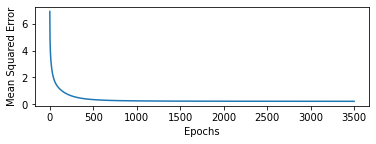

Testing
Testing MSE is  0.20673115615462304
Testing MAE is  0.3642120957167318


In [67]:
GD4 = PolynomialRegression(4)
x_train_trans_4 = GD4.transform(train_X)
GD4.fit(x_train_trans_4, train_y, epochs = 3500, learning='GD', learning_rate=0.02)
x_test_trans_4 = GD4.transform(test_X)
GD4.evaluate(x_test_trans_4 , test_y)

In [69]:
wGD4 = GD4.w

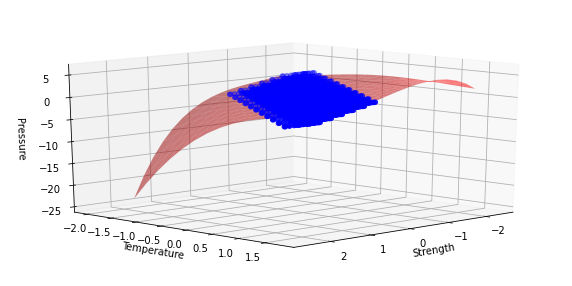

In [71]:
# plot for 0 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
Z=genCurve(wGD4,xx,yy,4)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

##### SGD

Training...


  0%|          | 0/5000 [00:00<?, ?epoch/s]

Epoch: 0  MSE Loss : 329.6511998196053
Epoch: 50  MSE Loss : 27.239314513417618
Epoch: 100  MSE Loss : 10.659045279571604
Epoch: 150  MSE Loss : 1.7073484991571526
Epoch: 200  MSE Loss : 8.569205519201127
Epoch: 250  MSE Loss : 1.5432233625634773
Epoch: 300  MSE Loss : 2.252633886868228
Epoch: 350  MSE Loss : 1.4148579693305077
Epoch: 400  MSE Loss : 1.2136648081490145
Epoch: 450  MSE Loss : 2.698762210715308
Epoch: 500  MSE Loss : 30.527143928916256
Epoch: 550  MSE Loss : 10.64752971349345
Epoch: 600  MSE Loss : 2.4833262314365383
Epoch: 650  MSE Loss : 1.1876637470374722
Epoch: 700  MSE Loss : 0.9116670816800962
Epoch: 750  MSE Loss : 0.936461669546968
Epoch: 800  MSE Loss : 0.9638722155142555
Epoch: 850  MSE Loss : 0.8605759800838172
Epoch: 900  MSE Loss : 1.2088046725574797
Epoch: 950  MSE Loss : 0.6998470125688748
Epoch: 1000  MSE Loss : 1.0489234742009816
Epoch: 1050  MSE Loss : 6.559470959506789
Epoch: 1100  MSE Loss : 0.8479571701380918
Epoch: 1150  MSE Loss : 0.656989728138988

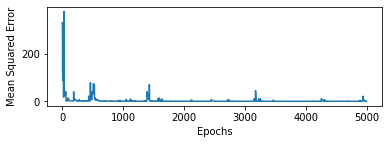

Testing
Testing MSE is  0.26236606577615834
Testing MAE is  0.416484511963791


In [133]:
SGD4 = PolynomialRegression(4)
x_train_trans_4 = SGD4.transform(train_X)
SGD4.fit(x_train_trans_4, train_y, epochs = 5000, learning='SGD', learning_rate=0.0029)
x_test_trans_4 = SGD4.transform(test_X)
SGD4.evaluate(x_test_trans_4 , test_y)

In [134]:
wSGD4 = SGD4.w

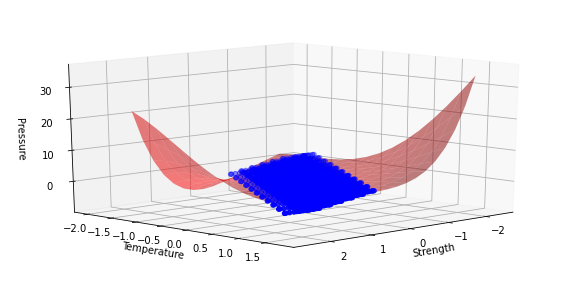

In [135]:
# plot for 0 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
Z=genCurve(wSGD4,xx,yy,4)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

### 5 Degree Polynomial

##### GD

Training...


  0%|          | 0/5000 [00:00<?, ?epoch/s]

Epoch: 0  MSE Loss : 141.93575658570512
Epoch: 50  MSE Loss : 1.6425018604133907
Epoch: 100  MSE Loss : 1.3704022009077261
Epoch: 150  MSE Loss : 1.202524263575567
Epoch: 200  MSE Loss : 1.0756703234385623
Epoch: 250  MSE Loss : 0.9742086266646585
Epoch: 300  MSE Loss : 0.8904019786692947
Epoch: 350  MSE Loss : 0.8197163854302201
Epoch: 400  MSE Loss : 0.7592409279692153
Epoch: 450  MSE Loss : 0.706967230316212
Epoch: 500  MSE Loss : 0.6614294402288522
Epoch: 550  MSE Loss : 0.6215113336453515
Epoch: 600  MSE Loss : 0.5863358871585026
Epoch: 650  MSE Loss : 0.5551980117794476
Epoch: 700  MSE Loss : 0.5275211856102482
Epoch: 750  MSE Loss : 0.5028280416645903
Epoch: 800  MSE Loss : 0.48071952120395467
Epoch: 850  MSE Loss : 0.460859536558096
Epoch: 900  MSE Loss : 0.442963335901959
Epoch: 950  MSE Loss : 0.4267884568666385
Epoch: 1000  MSE Loss : 0.4121275560425262
Epoch: 1050  MSE Loss : 0.3988026399494977
Epoch: 1100  MSE Loss : 0.38666037000404296
Epoch: 1150  MSE Loss : 0.3755682076

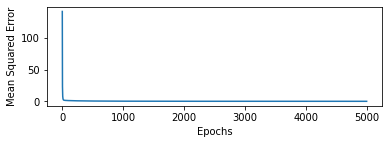

Testing
Testing MSE is  0.2115524495068966
Testing MAE is  0.3695551212291927


In [82]:
GD5 = PolynomialRegression(5)
x_train_trans_5 = GD5.transform(train_X)
GD5.fit(x_train_trans_5, train_y, epochs = 5000, learning='GD', learning_rate=0.007)
x_test_trans_5 = GD5.transform(test_X)
GD5.evaluate(x_test_trans_5 , test_y)

In [84]:
wGD5 = GD5.w

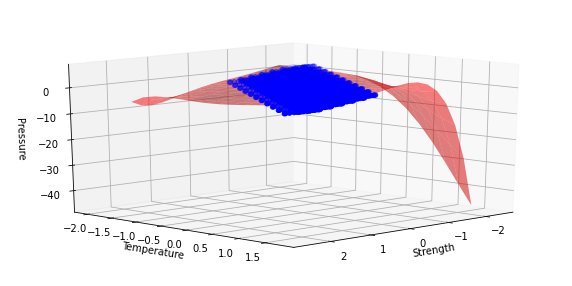

In [85]:
# plot for 0 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
Z=genCurve(wGD5,xx,yy,5)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

##### SGD

Training...


  0%|          | 0/25000 [00:00<?, ?epoch/s]

Epoch: 0  MSE Loss : 64.11212954094552
Epoch: 50  MSE Loss : 83.2087921821632
Epoch: 100  MSE Loss : 25.01616957451464
Epoch: 150  MSE Loss : 22.599607118651473
Epoch: 200  MSE Loss : 10.731630694827563
Epoch: 250  MSE Loss : 11.663364573018372
Epoch: 300  MSE Loss : 9.200217641826452
Epoch: 350  MSE Loss : 80.91586999950971
Epoch: 400  MSE Loss : 81.37577476052013
Epoch: 450  MSE Loss : 48.6127798125491
Epoch: 500  MSE Loss : 7.967076240002335
Epoch: 550  MSE Loss : 7.576624131529407
Epoch: 600  MSE Loss : 9.79049100201614
Epoch: 650  MSE Loss : 5.7443855376986175
Epoch: 700  MSE Loss : 6.63494729859213
Epoch: 750  MSE Loss : 6.596233510538436
Epoch: 800  MSE Loss : 7.018357178148479
Epoch: 850  MSE Loss : 18.224404802347344
Epoch: 900  MSE Loss : 8.004565355416204
Epoch: 950  MSE Loss : 7.424900098707109
Epoch: 1000  MSE Loss : 5.944123353088866
Epoch: 1050  MSE Loss : 4.777554439338281
Epoch: 1100  MSE Loss : 4.441824548209239
Epoch: 1150  MSE Loss : 4.111623018168317
Epoch: 1200  M

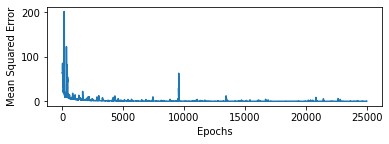

Testing
Testing MSE is  0.3642299990683186
Testing MAE is  0.46535462741198885


In [179]:
SGD5 = PolynomialRegression(5)
x_train_trans_5 = SGD5.transform(train_X)
SGD5.fit(x_train_trans_5, train_y, epochs = 25000, learning='SGD', learning_rate=0.00035)
x_test_trans_5 = SGD5.transform(test_X)
SGD5.evaluate(x_test_trans_5 , test_y)

In [180]:
wSGD5 = SGD5.w

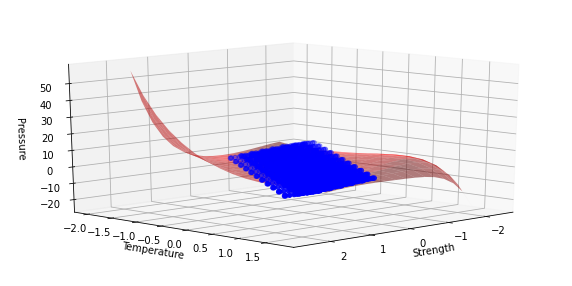

In [181]:
# plot for 0 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
Z=genCurve(wSGD5,xx,yy,5)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

### 6 Degree Polynomial

##### GD

Training...


  0%|          | 0/10000 [00:00<?, ?epoch/s]

Epoch: 0  MSE Loss : 236.17637365337504
Epoch: 50  MSE Loss : 6.225632954162549
Epoch: 100  MSE Loss : 4.877365929598291
Epoch: 150  MSE Loss : 4.134380260338977
Epoch: 200  MSE Loss : 3.617679500484889
Epoch: 250  MSE Loss : 3.220025462383887
Epoch: 300  MSE Loss : 2.9008323577787913
Epoch: 350  MSE Loss : 2.6393418358675937
Epoch: 400  MSE Loss : 2.4222573941540495
Epoch: 450  MSE Loss : 2.240040216265988
Epoch: 500  MSE Loss : 2.085516949662179
Epoch: 550  MSE Loss : 1.9531837227316036
Epoch: 600  MSE Loss : 1.8387728677211208
Epoch: 650  MSE Loss : 1.7389507904376909
Epoch: 700  MSE Loss : 1.6510969288300936
Epoch: 750  MSE Loss : 1.5731387310089375
Epoch: 800  MSE Loss : 1.503427208297197
Epoch: 850  MSE Loss : 1.440642471811872
Epoch: 900  MSE Loss : 1.3837216470099956
Epoch: 950  MSE Loss : 1.331803596304231
Epoch: 1000  MSE Loss : 1.2841863306077164
Epoch: 1050  MSE Loss : 1.2402940445947834
Epoch: 1100  MSE Loss : 1.1996514835074767
Epoch: 1150  MSE Loss : 1.1618639198207095
E

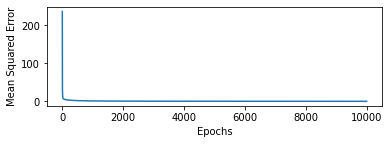

Testing
Testing MSE is  0.24724983822671132
Testing MAE is  0.401297765244595


In [195]:
GD6 = PolynomialRegression(6) 
x_train_trans_6 = GD6.transform(train_X)
GD6.fit(x_train_trans_6, train_y, epochs = 10000, learning='GD', learning_rate=0.00238)
x_test_trans_6 = GD6.transform(test_X)
GD6.evaluate(x_test_trans_6 , test_y)

In [196]:
wGD6 = GD6.w

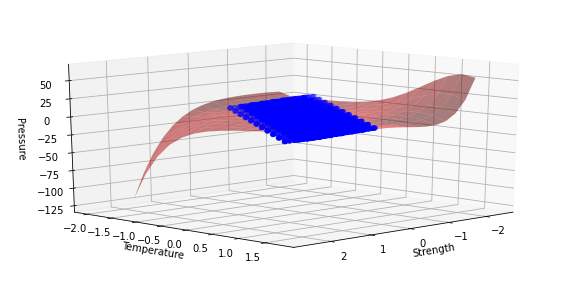

In [197]:
# plot for 0 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
Z=genCurve(wGD6,xx,yy,6)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

##### SGD

Training...


  0%|          | 0/90000 [00:00<?, ?epoch/s]

Epoch: 0  MSE Loss : 2181.138407801454
Epoch: 50  MSE Loss : 732.4046176707604
Epoch: 100  MSE Loss : 803.9645073439341
Epoch: 150  MSE Loss : 300.8913287277685
Epoch: 200  MSE Loss : 225.618949051276
Epoch: 250  MSE Loss : 326.9435251356045
Epoch: 300  MSE Loss : 103.37949294104584
Epoch: 350  MSE Loss : 72.8088397715503
Epoch: 400  MSE Loss : 91.4883565009566
Epoch: 450  MSE Loss : 73.6363140150447
Epoch: 500  MSE Loss : 40.57902654148975
Epoch: 550  MSE Loss : 50.443114103068474
Epoch: 600  MSE Loss : 37.660908338185685
Epoch: 650  MSE Loss : 64.07912074799881
Epoch: 700  MSE Loss : 54.97012455422461
Epoch: 750  MSE Loss : 94.48775682522131
Epoch: 800  MSE Loss : 45.53431828726826
Epoch: 850  MSE Loss : 25.270124997807557
Epoch: 900  MSE Loss : 22.656312070041988
Epoch: 950  MSE Loss : 18.781810856908045
Epoch: 1000  MSE Loss : 17.68858928582372
Epoch: 1050  MSE Loss : 18.68043142354448
Epoch: 1100  MSE Loss : 20.189969260327725
Epoch: 1150  MSE Loss : 13.714814584437002
Epoch: 1200

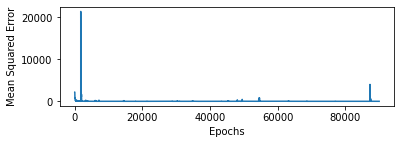

Testing
Testing MSE is  0.37793939133278853
Testing MAE is  0.4810974866024516


In [215]:
SGD6 = PolynomialRegression(6)
x_train_trans_6 = SGD6.transform(train_X)
SGD6.fit(x_train_trans_6, train_y, epochs = 90000, learning='SGD', learning_rate=0.000074)
x_test_trans_6 = SGD6.transform(test_X)
SGD6.evaluate(x_test_trans_6 , test_y)

In [216]:
wSGD6 = SGD6.w

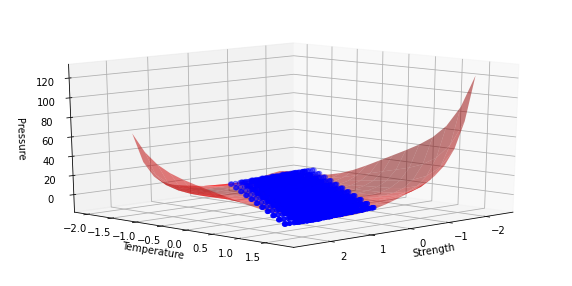

In [217]:
# plot for 0 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
Z=genCurve(wSGD6,xx,yy,6)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

### 7 Degree Polynomial

##### GD

Training...


  0%|          | 0/60000 [00:00<?, ?epoch/s]

Epoch: 0  MSE Loss : 2928.5482261579623
Epoch: 50  MSE Loss : 18.86154897846863
Epoch: 100  MSE Loss : 14.955663936786522
Epoch: 150  MSE Loss : 12.121875997987305
Epoch: 200  MSE Loss : 9.982063750389573
Epoch: 250  MSE Loss : 8.33962687592027
Epoch: 300  MSE Loss : 7.06752910277205
Epoch: 350  MSE Loss : 6.075941690879635
Epoch: 400  MSE Loss : 5.298566931518717
Epoch: 450  MSE Loss : 4.6855150169924595
Epoch: 500  MSE Loss : 4.198910041235139
Epoch: 550  MSE Loss : 3.8098723114721595
Epoch: 600  MSE Loss : 3.4963269566884
Epoch: 650  MSE Loss : 3.2413706546429917
Epoch: 700  MSE Loss : 3.0320400206564346
Epoch: 750  MSE Loss : 2.858377880894405
Epoch: 800  MSE Loss : 2.7127234842664305
Epoch: 850  MSE Loss : 2.5891721090811926
Epoch: 900  MSE Loss : 2.4831631942553254
Epoch: 950  MSE Loss : 2.391166150554863
Epoch: 1000  MSE Loss : 2.310440492972746
Epoch: 1050  MSE Loss : 2.238852570851636
Epoch: 1100  MSE Loss : 2.1747354318601113
Epoch: 1150  MSE Loss : 2.116781582250831
Epoch: 1

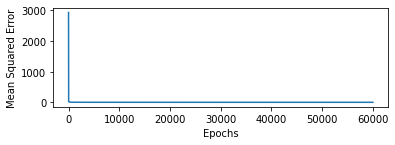

Testing
Testing MSE is  0.2534382066303367
Testing MAE is  0.4078569576166002


In [226]:
GD7 = PolynomialRegression(7) 
x_train_trans_7 = GD7.transform(train_X)
GD7.fit(x_train_trans_7, train_y, epochs = 60000, learning='GD', learning_rate=0.0005)
x_test_trans_7 = GD7.transform(test_X)
GD7.evaluate(x_test_trans_7 , test_y)

In [227]:
wGD7 = GD7.w

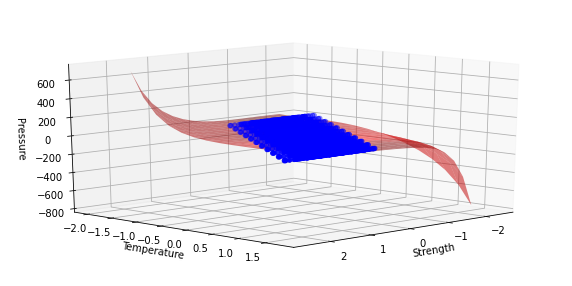

In [228]:
# plot for 0 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
Z=genCurve(wGD7,xx,yy,7)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

##### SGD

Training...


  0%|          | 0/200000 [00:00<?, ?epoch/s]

Epoch: 0  MSE Loss : 1758.1179074385277
Epoch: 50  MSE Loss : 1905.85588647983
Epoch: 100  MSE Loss : 367.38510493100705
Epoch: 150  MSE Loss : 266.37093457367666
Epoch: 200  MSE Loss : 296.80828865290016
Epoch: 250  MSE Loss : 172.70172972082804
Epoch: 300  MSE Loss : 159.63093076828198
Epoch: 350  MSE Loss : 135.03101548807695
Epoch: 400  MSE Loss : 119.99585006754585
Epoch: 450  MSE Loss : 94.2432945632253
Epoch: 500  MSE Loss : 87.8245726304566
Epoch: 550  MSE Loss : 83.18278518911343
Epoch: 600  MSE Loss : 86.59196859484133
Epoch: 650  MSE Loss : 77.56701702553221
Epoch: 700  MSE Loss : 57.313854410795514
Epoch: 750  MSE Loss : 56.40619220465619
Epoch: 800  MSE Loss : 54.08081864385417
Epoch: 850  MSE Loss : 234.1548951938343
Epoch: 900  MSE Loss : 553.7879717590469
Epoch: 950  MSE Loss : 63.44514572625191
Epoch: 1000  MSE Loss : 58.481490286855994
Epoch: 1050  MSE Loss : 234.12034960508421
Epoch: 1100  MSE Loss : 1155.0632677402944
Epoch: 1150  MSE Loss : 53.206678821041464
Epoch

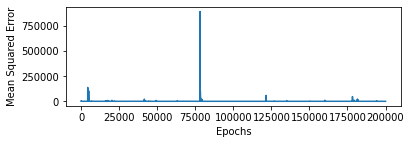

Testing
Testing MSE is  0.6372989055456555
Testing MAE is  0.6301116799291689


In [250]:
SGD7 = PolynomialRegression(7)
x_train_trans_7 = SGD7.transform(train_X)
SGD7.fit(x_train_trans_7, train_y, epochs = 200000, learning='SGD', learning_rate=0.0000112)
x_test_trans_7 = SGD7.transform(test_X)
SGD7.evaluate(x_test_trans_7 , test_y)

In [251]:
wSGD7 = SGD7.w

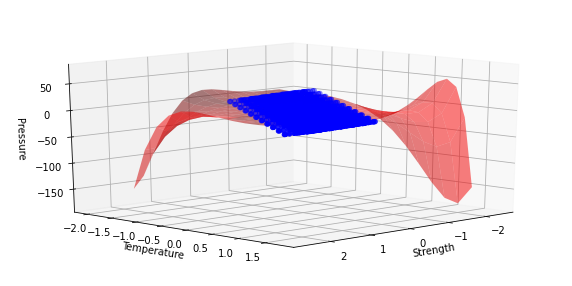

In [252]:
# plot for 0 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
Z=genCurve(wSGD7,xx,yy,7)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

### 8 Degree Polynomial

##### GD

Training...


  0%|          | 0/150000 [00:00<?, ?epoch/s]

Epoch: 0  MSE Loss : 53165.718407837216
Epoch: 50  MSE Loss : 42306.10155063306
Epoch: 100  MSE Loss : 33956.66307055381
Epoch: 150  MSE Loss : 27277.63111060257
Epoch: 200  MSE Loss : 21918.05074946625
Epoch: 250  MSE Loss : 17613.533988777646
Epoch: 300  MSE Loss : 14155.34394818329
Epoch: 350  MSE Loss : 11376.730746272817
Epoch: 400  MSE Loss : 9144.01390684392
Epoch: 450  MSE Loss : 7349.884958331803
Epoch: 500  MSE Loss : 5908.15774050441
Epoch: 550  MSE Loss : 4749.593596149855
Epoch: 600  MSE Loss : 3818.5623842275745
Epoch: 650  MSE Loss : 3070.3653119707433
Epoch: 700  MSE Loss : 2469.085944690824
Epoch: 750  MSE Loss : 1985.8642600805479
Epoch: 800  MSE Loss : 1597.5101139853361
Epoch: 850  MSE Loss : 1285.3892364705348
Epoch: 900  MSE Loss : 1034.5281392582342
Epoch: 950  MSE Loss : 832.8948966874245
Epoch: 1000  MSE Loss : 670.8212357430509
Epoch: 1050  MSE Loss : 540.538168319675
Epoch: 1100  MSE Loss : 435.80285677894744
Epoch: 1150  MSE Loss : 351.5987878424713
Epoch: 1

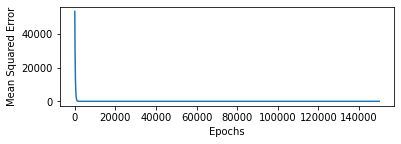

Testing
Testing MSE is  0.34878270855750704
Testing MAE is  0.4830438337653215


In [264]:
GD8 = PolynomialRegression(8) 
x_train_trans_8 = GD8.transform(train_X)
GD8.fit(x_train_trans_8, train_y, epochs = 150000, learning='GD', learning_rate=0.00011)
x_test_trans_8 = GD8.transform(test_X)
GD8.evaluate(x_test_trans_8 , test_y)

In [265]:
wGD8 = GD8.w

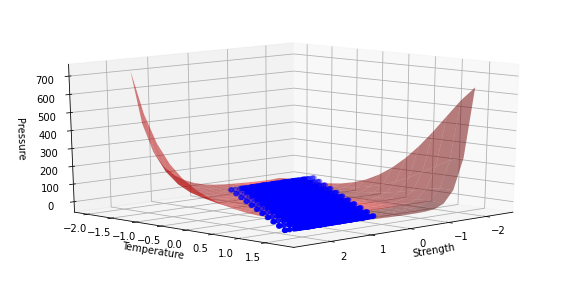

In [266]:
# plot for 0 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
Z=genCurve(wGD8,xx,yy,8)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

##### SGD

Training...


  0%|          | 0/700000 [00:00<?, ?epoch/s]

Streaming output truncated to the last 5000 lines.
Epoch: 450000  MSE Loss : 1.3784782421080217
Epoch: 450050  MSE Loss : 1.7909036032111267
Epoch: 450100  MSE Loss : 1.445471583434008
Epoch: 450150  MSE Loss : 1.3975416994913399
Epoch: 450200  MSE Loss : 1.858794369386535
Epoch: 450250  MSE Loss : 1.350655306135271
Epoch: 450300  MSE Loss : 41.13264889026029
Epoch: 450350  MSE Loss : 12.301453744370578
Epoch: 450400  MSE Loss : 3.089032397763404
Epoch: 450450  MSE Loss : 2.458798317628353
Epoch: 450500  MSE Loss : 1.345124236724931
Epoch: 450550  MSE Loss : 1.3857462666832214
Epoch: 450600  MSE Loss : 1.3863681789074271
Epoch: 450650  MSE Loss : 1.3265235771200714
Epoch: 450700  MSE Loss : 1.230473025957945
Epoch: 450750  MSE Loss : 1.243553223231508
Epoch: 450800  MSE Loss : 1.42056906173172
Epoch: 450850  MSE Loss : 15.426578396569653
Epoch: 450900  MSE Loss : 143.74016246426407
Epoch: 450950  MSE Loss : 84.2055676123614
Epoch: 451000  MSE Loss : 14.306605001769938
Epoch: 451050  MS

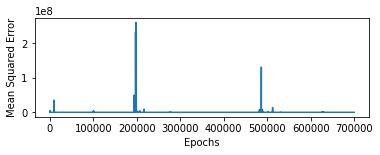

Testing
Testing MSE is  0.8251040060808154
Testing MAE is  0.7062730457725416


In [300]:
SGD8 = PolynomialRegression(8)
x_train_trans_8 = SGD8.transform(train_X)
SGD8.fit(x_train_trans_8, train_y, epochs = 700000, learning='SGD', learning_rate=0.00000175)
x_test_trans_8 = SGD8.transform(test_X)
SGD8.evaluate(x_test_trans_8 , test_y)

In [301]:
wSGD8 = SGD8.w

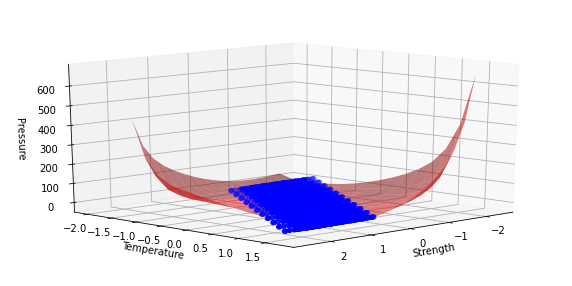

In [304]:
# plot for 0 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
Z=genCurve(wSGD8,xx,yy,8)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

### 9 Degree Polynomial

##### GD

Training...


  0%|          | 0/400000 [00:00<?, ?epoch/s]

Streaming output truncated to the last 5000 lines.
Epoch: 150000  MSE Loss : 0.7768274717238776
Epoch: 150050  MSE Loss : 0.776556487471674
Epoch: 150100  MSE Loss : 0.7762857332565622
Epoch: 150150  MSE Loss : 0.7760152088502977
Epoch: 150200  MSE Loss : 0.7757449140248919
Epoch: 150250  MSE Loss : 0.7754748485525984
Epoch: 150300  MSE Loss : 0.7752050122059284
Epoch: 150350  MSE Loss : 0.7749354047576525
Epoch: 150400  MSE Loss : 0.774666025980773
Epoch: 150450  MSE Loss : 0.7743968756485684
Epoch: 150500  MSE Loss : 0.7741279535345393
Epoch: 150550  MSE Loss : 0.7738592594124555
Epoch: 150600  MSE Loss : 0.7735907930563323
Epoch: 150650  MSE Loss : 0.7733225542404331
Epoch: 150700  MSE Loss : 0.7730545427392628
Epoch: 150750  MSE Loss : 0.7727867583275879
Epoch: 150800  MSE Loss : 0.7725192007804174
Epoch: 150850  MSE Loss : 0.77225186987301
Epoch: 150900  MSE Loss : 0.7719847653808684
Epoch: 150950  MSE Loss : 0.7717178870797429
Epoch: 151000  MSE Loss : 0.771451234745639
Epoch: 15

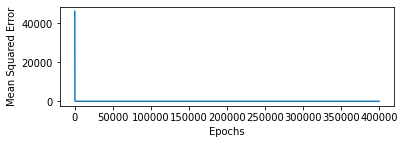

Testing
Testing MSE is  0.42587303221245354
Testing MAE is  0.5321588120662094


In [314]:
GD9 = PolynomialRegression(9) 
x_train_trans_9 = GD9.transform(train_X)
GD9.fit(x_train_trans_9, train_y, epochs = 400000, learning='GD', learning_rate=0.000021)
x_test_trans_9 = GD9.transform(test_X)
GD9.evaluate(x_test_trans_9 , test_y)

In [315]:
wGD9 = GD9.w

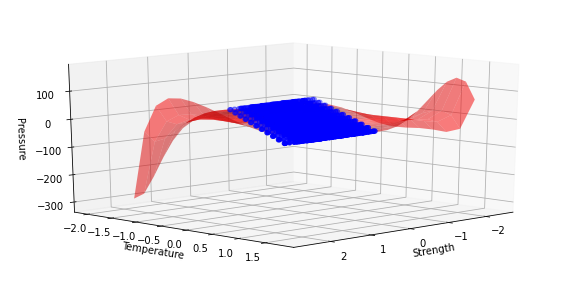

In [316]:
# plot for 0 degree polynomial GD

plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
Z=genCurve(wGD9,xx,yy,9)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()

##### SGD

Training...


  0%|          | 0/3000000 [00:00<?, ?epoch/s]

Streaming output truncated to the last 5000 lines.
Epoch: 2750000  MSE Loss : 18.32172624766939
Epoch: 2750050  MSE Loss : 18.960714642702886
Epoch: 2750100  MSE Loss : 13.693328585491532
Epoch: 2750150  MSE Loss : 12.394979652061735
Epoch: 2750200  MSE Loss : 11.21051104547442
Epoch: 2750250  MSE Loss : 6.538887335196318
Epoch: 2750300  MSE Loss : 24.542167155668434
Epoch: 2750350  MSE Loss : 300.49983461369976
Epoch: 2750400  MSE Loss : 188.47635666252043
Epoch: 2750450  MSE Loss : 13.75842557054342
Epoch: 2750500  MSE Loss : 14.78639274956523
Epoch: 2750550  MSE Loss : 12.214662977843087
Epoch: 2750600  MSE Loss : 13.001675972815452
Epoch: 2750650  MSE Loss : 12.925563104128976
Epoch: 2750700  MSE Loss : 11.190190279307938
Epoch: 2750750  MSE Loss : 9.395743756109391
Epoch: 2750800  MSE Loss : 7.197624279456505
Epoch: 2750850  MSE Loss : 7.299336722024907
Epoch: 2750900  MSE Loss : 8.169414668395522
Epoch: 2750950  MSE Loss : 5.87510487150957
Epoch: 2751000  MSE Loss : 5.06204229182

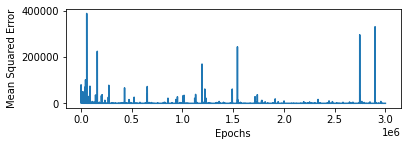

Testing
Testing MSE is  4.030683949925308
Testing MAE is  1.285866958441079


In [346]:
SGD9 = PolynomialRegression(9)
x_train_trans_9 = SGD9.transform(train_X)
SGD9.fit(x_train_trans_9, train_y, epochs = 3000000, learning='SGD', learning_rate=0.000000198)
x_test_trans_9 = SGD9.transform(test_X)
SGD9.evaluate(x_test_trans_9 , test_y)

In [344]:
wSGD9 = SGD9.w

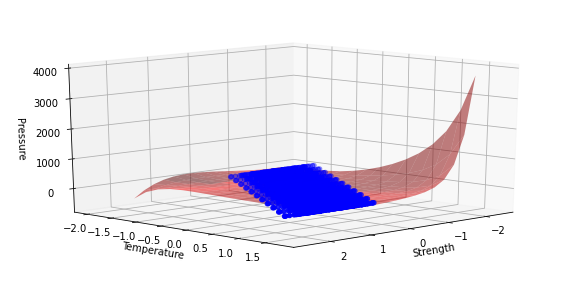

In [345]:


plt.figure(figsize=(10, 5))
ax = plt.axes(projection='3d')

xx,yy = np.meshgrid(np.arange(-2, 2, 0.25), np.arange(-2, 2, 0.25))
Z=genCurve(wSGD9,xx,yy,9)

ax.plot_surface(xx, yy, Z, alpha=0.5, color='r')
ax.scatter3D(X[:,0], X[:,1], y, c='b' )
ax.set_xlabel("Strength")
ax.set_ylabel("Temperature")
ax.set_zlabel("Pressure")
ax.view_init(15,45)

plt.show()